In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision import datasets, models, transforms
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset,DataLoader

# 定义超参数

In [19]:
# 定义是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCH = 1   #遍历数据集次数
pre_epoch = 0  # 定义已经遍历数据集的次数
BATCH_SIZE = 128   #批处理尺寸(batch_size)
LR = 0.0001        #学习率

# 数据预处理

In [20]:
# 准备数据集并预处理

class MyDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imgs = imageFolderDataset.imgs    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self, index):
        fn, label = self.imgs[index]
        #print(fn)   图片地址
        #print(label)   图片类别，cat=0，dog=1
        img = Image.open(fn).convert('RGB')
             
        if self.should_invert:
            img = PIL.ImageOps.invert(img)   #invert：图片取反
            
        if self.transform is not None:
            img = self.transform(img) 
            
        return img, label
    
    def __len__(self):
        return len(self.imgs)

# transform_train = transforms.Compose([
#     transforms.Resize((150, 150)),
#     transforms.RandomHorizontalFlip(0.5),  # 图像一半的概率翻转，一半的概率不翻转
#     transforms.RandomVerticalFlip(0.5),  # 竖直翻转
#     transforms.RandomRotation(30),
#     transforms.RandomCrop(128, padding=4),
# #    transforms.ColorJitter(brightness=0.5),
# #    transforms.ColorJitter(contrast=0),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #R,G,B每层的归一化用到的均值和方差
# ])

# transform_val = transforms.Compose([
#     transforms.Resize((128, 128)), # 调整图像大小
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ])

transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

train_dir = 'D:/数据库/dog_vs_cat/train/'
val_dir = 'D:/数据库/dog_vs_cat/val/'

train_dataset=torchvision.datasets.ImageFolder(root=train_dir)
val_dataset=torchvision.datasets.ImageFolder(root=val_dir)

training_set=MyDataset(imageFolderDataset=train_dataset,transform=transform,should_invert=False)
valing_set=MyDataset(imageFolderDataset=val_dataset,transform=transform,should_invert=False)

training_loader = DataLoader(training_set,shuffle=True,batch_size=BATCH_SIZE,num_workers=0)
valing_loader = DataLoader(valing_set,shuffle=True,batch_size=BATCH_SIZE,num_workers=0)



In [21]:
print(next(iter(training_loader))[0].shape)  #torch.Size([128, 3, 128, 128])
print(next(iter(training_loader))[1].shape)  #torch.Size([128])

torch.Size([128, 3, 224, 224])
torch.Size([128])


# 可视化

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


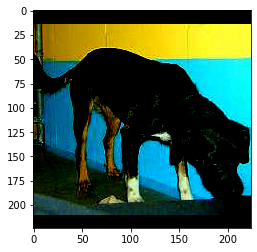

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


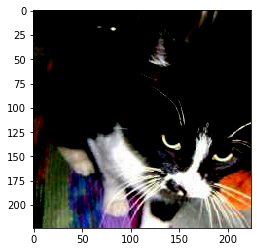

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)


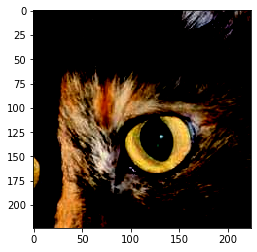

In [22]:
to_pil_image = transforms.ToPILImage()
cnt = 0
for image,label in training_loader:
    if cnt>=3: # 只显示3张图片
        break
    img = image[0] # plt.imshow()只能接受3-D Tensor，所以也要用image[0]消去batch那一维
    img = img.numpy() # FloatTensor转为ndarray
    img = np.transpose(img, (1,2,0)) # 把channel那一维放到最后
    print(label[cnt]) # 显示label
    # 显示图片
    plt.imshow(img)
    plt.show()
    cnt += 1

# 调用与训练的vgg16

In [14]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=2):   # num_classes，此处为 二分类值为2
        super(VGGNet, self).__init__()
        net = models.vgg16(pretrained=True)   # 从预训练模型加载VGG16网络参数
        net.classifier = nn.Sequential()  # 将分类层置空，下面将改变我们的分类层
        self.features = net  # 保留VGG16的特征层
        self.classifier = nn.Sequential(    # 定义自己的分类层
                nn.Linear(512 * 7 * 7, 1024),  #512 * 7 * 7不能改变 ，由VGG16网络决定的，第二个参数为神经元个数可以微调
                nn.ReLU(True),
                nn.Dropout(0.3),
                nn.Linear(1024, 1024),
                nn.ReLU(True),
                nn.Dropout(0.3),
                nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x) # 预训练提供的提取特征的部分
        x = x.view(x.size(0), -1)
        x = self.classifier(x) # 自定义的分类部分
        return x
net = VGGNet().to(device)
print(net)

VGGNet(
  (features): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): MaxPool2d(kernel_size=2, stride=2

# 定义两个函数，一个可以冻住features层，只训练FC层，另一个把features层解冻，训练所有参数

In [111]:
from collections.abc import Iterable
def set_freeze_by_names(model, layer_names, freeze=True):
    if not isinstance(layer_names, Iterable):
        layer_names = [layer_names]
    for name, child in model.named_children():
        if name not in layer_names:
            continue
        for param in child.parameters():
            param.requires_grad = not freeze

def freeze_by_names(model, layer_names):   #冻结某层
    set_freeze_by_names(model, layer_names, True)

def unfreeze_by_names(model, layer_names):  #解冻某层
    set_freeze_by_names(model, layer_names, False)
    

In [116]:
freeze_by_names(net,['features','avgpool','classifier'])
unfreeze_by_names(net,'classifier')

In [114]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
criterion.to(device=device)

CrossEntropyLoss()

In [ ]:
y_predict = []
y_true = []

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 训练模型

In [130]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print("Start Training!")  # 定义遍历数据集的次数
for epoch in range(pre_epoch, EPOCH):
    print('\nEpoch: %d' % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(training_loader, 0):
        # 准备数据
        length = len(training_loader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        with torch.no_grad():
            # forward + backward
            outputs = net(inputs)
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # 每训练1个batch打印一次loss和准确率
        sum_loss += loss.item()
        
#         # 使用Top5分类
#         maxk = max((1,5))
#         label_resize = labels.view(-1, 1)
#         _, predicted = outputs.topk(maxk, 1, True, True)
#         total += labels.size(0)
#         correct += torch.eq(predicted, label_resize).cpu().sum().float().item()
            
#         print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% '% (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))
    
    # 每训练完一个epoch测试一下准确率
#     print("Waiting Test!")
#     with torch.no_grad():
#         correct = 0
#         total = 0
#         for data in valing_loader:
#             net.eval()
#             images, labels = data
#             images, labels = images.to(device), labels.to(device)
#             outputs = net(images)
#             # 取得分最高的那个类 (outputs.data的索引号)
            
#             maxk = max((1,5))
#             label_resize = labels.view(-1, 1)
#             _, predicted = outputs.topk(maxk, 1, True, True)
#             total += labels.size(0)
#             correct += torch.eq(predicted, label_resize).cpu().sum().float().item()
            
#             y_predict.append(predicted)
#             y_true.append(labels)
#         print('测试分类准确率为：%.3f%%' % (100 * correct / total))
#         acc = 100. * correct / total
#print("Training Finished, TotalEPOCH=%d" % EPOCH)

Start Training!

Epoch: 1


RuntimeError: CUDA out of memory. Tried to allocate 1.53 GiB (GPU 0; 2.00 GiB total capacity; 599.15 MiB already allocated; 0 bytes free; 998.50 KiB cached)

In [ ]:
#保存模型
torch.save(net, './model/mobileNet freeze.pth')
#加载模型
net = torch.load('./model/VGG16-2 freeze.pth')

# resnet18

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes=685):   # num_classes，此处为 二分类值为2
        super(ResNet, self).__init__()
        net = models.resnet18(pretrained=True)   # 从预训练模型加载VGG16网络参数
        net.classifier = nn.Sequential()  # 将分类层置空，下面将改变我们的分类层
        self.features = net  # 保留VGG16的特征层
        self.classifier = nn.Sequential(    # 定义自己的分类层
                nn.Linear(1000, 1000),  #1000不能改变 ，由VGG16网络决定的，第二个参数为神经元个数可以微调
                nn.ReLU(True),
                nn.Dropout(0.5),
#                 nn.Linear(1024, 1024),
#                 nn.ReLU(True),
#                 nn.Dropout(0.3),
                nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
net = ResNet().to(device)

# MobileNet V2的预训练模型

In [132]:
class MobileNet(nn.Module):
    def __init__(self, num_classes=685):   # num_classes，此处为 二分类值为2
        super(MobileNet, self).__init__()
        net = models.mobilenet_v2(pretrained=True)   # 从预训练模型加载VGG16网络参数
        net.classifier = nn.Sequential()  # 将分类层置空，下面将改变我们的分类层
        self.features = net  # 保留VGG16的特征层
        self.classifier = nn.Sequential(    # 定义自己的分类层
                nn.Linear(1280, 1000),  #512 * 7 * 7不能改变 ，由VGG16网络决定的，第二个参数为神经元个数可以微调
                nn.ReLU(True),
                nn.Dropout(0.5),
#                 nn.Linear(1024, 1024),
#                 nn.ReLU(True),
#                 nn.Dropout(0.3),
                nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
net = MobileNet().to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\user/.torch\models\mobilenet_v2-b0353104.pth
14212972it [02:25, 97590.37it/s] 
